## Overfitting

We've seen in previous lessons how we can construct neural networks with many neurons arranged into as many layers as we wish. This flexibility is what gives neural networks their power; however, it can also cause practical challenges. 

If we use too complicated of a network to fit a relatively small and simple dataset, the network may "learn" the noise present in our data rather than the actual useful patterns that the dataset contains. This phenomenon is called "overfitting," and it can have unfortunate consequences. Overfit models may effectively memorize every detail of the dataset on which they were trained, but they will fail to generalize when presented with new data and cannot be relied upon to yield accurate predictions.

We will now demonstrate how overfitting occurs with a simple example. We'll need these libraries:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from visualization import draw_nn_graph
from consistency import remove_randomness
remove_randomness()

We'll work with the simple `x` and `y` training dataset that is loaded and visualized below:

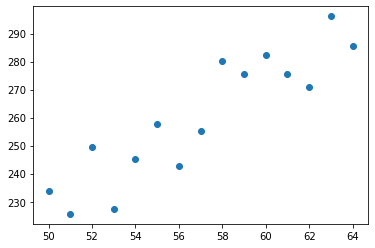

In [2]:
# load data
x_train = np.loadtxt("data/overfit_example_x_train.csv", delimiter=",")
y_train = np.loadtxt("data/overfit_example_y_train.csv", delimiter=",")
plt.scatter(x_train, y_train)
plt.show()

## Building a Simple Model (Not Overfit)

As you can see, the  data above looks like a (noisy) line. We'd expect a simple linear model like the one below to give accurate predictions for the values in this dataset:

In [3]:
# build model
model = keras.Sequential(
    [
        keras.layers.Dense(
            name="output",
            units=1,
            input_shape=(1,),
            kernel_initializer=tf.keras.initializers.ones,
            bias_initializer=tf.keras.initializers.zeros
        )
    ]
)

# configure for training
model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4),
    loss="mean_squared_error"
)

# train
model.fit(x_train,y_train,epochs=20)

Train on 15 samples
Epoch 1/20
15/15 [==============================] - 0s 27ms/sample - loss: 41601.9883
Epoch 2/20
15/15 [==============================] - 0s 218us/sample - loss: 5064.6592
Epoch 3/20
15/15 [==============================] - 0s 202us/sample - loss: 683.7819
Epoch 4/20
15/15 [==============================] - 0s 164us/sample - loss: 158.5091
Epoch 5/20
15/15 [==============================] - 0s 167us/sample - loss: 95.5280
Epoch 6/20
15/15 [==============================] - 0s 151us/sample - loss: 87.9766
Epoch 7/20
15/15 [==============================] - 0s 152us/sample - loss: 87.0711
Epoch 8/20
15/15 [==============================] - 0s 113us/sample - loss: 86.9625
Epoch 9/20
15/15 [==============================] - 0s 185us/sample - loss: 86.9495
Epoch 10/20
15/15 [==============================] - 0s 204us/sample - loss: 86.9480
Epoch 11/20
15/15 [==============================] - 0s 170us/sample - loss: 86.9478
Epoch 12/20
15/15 [=============================

Generating predicted `y` values from our model reveals that the predictions it has produced are reasonable:

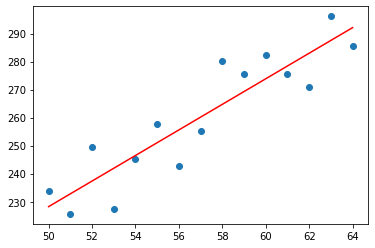

In [4]:
# visualize to demonstrate that our optimizer has found the best-fit line
y_pred_train = model.predict(x_train)
plt.scatter(x_train, y_train)
plt.plot(x_train, y_pred_train, c="r")
plt.show()

## Overfitting the Linear Trend

Let's now load a much more complicated model that has been trained against this same dataset:

In [5]:
model_overfit = tf.keras.models.load_model("models/relu_overfit.h5")

This model has a very large hidden layer consisting of many neurons:

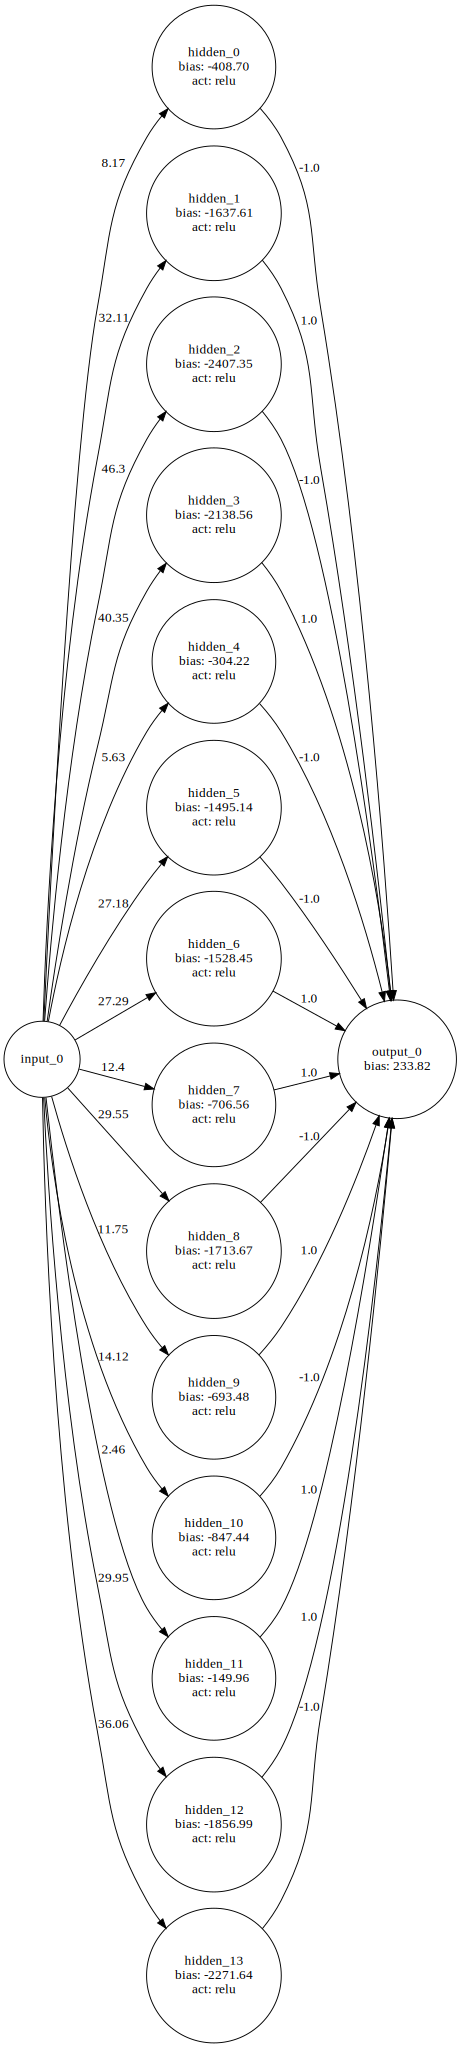

In [6]:
draw_nn_graph(model_overfit)

When we use this overfit model to predict the `y` values on which it was trained, it appears to have more predictive power than our original linear model. The predicted values from the overfit model (the green points) perfectly overlap the blue points from the actual dataset:

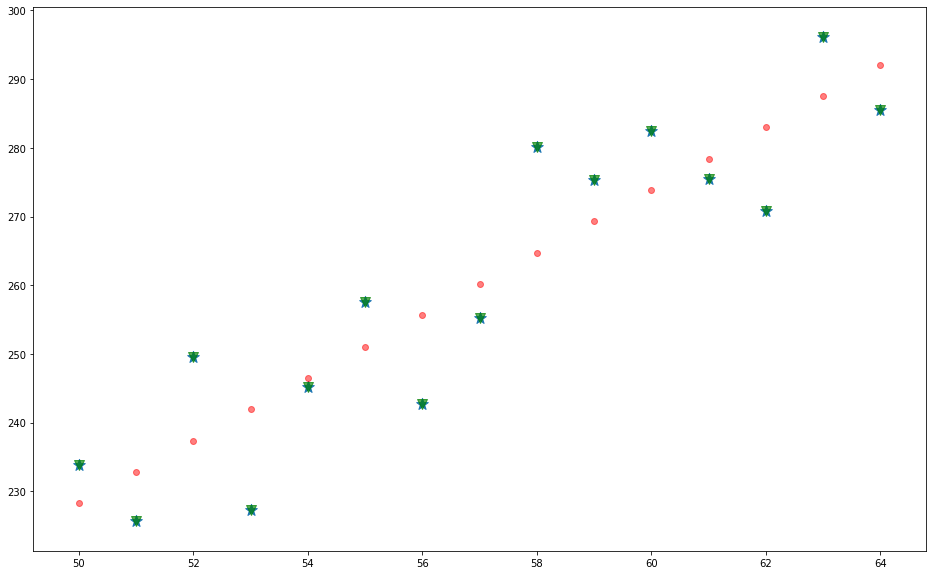

In [26]:
# model appears better
plt.figure(figsize=(16,10))
y_pred_train_overfit = model_overfit.predict(x_train)
plt.scatter(x_train, y_train, marker="*", alpha=1.0, s=150)
plt.scatter(x_train, y_pred_train, c="r", alpha=0.5)
plt.scatter(x_train, y_pred_train_overfit, c="g", alpha=0.67, s=100, marker="v")
plt.show()

Does this mean that the overfit model is better? Absolutely not - as we can see below, the overfit model has learned the oscillatory pattern of the noise in our dataset rather than the underlying linear trend:

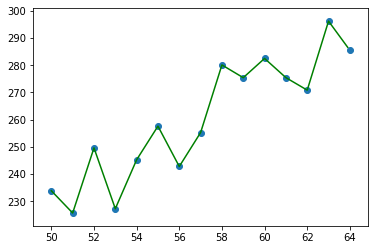

In [27]:
# but this is all a lie - as we can see, the model has fit itself to the noise
x_spacing = x_train[1] - x_train[0]
x_fine_grain = np.arange(x_train[0], x_train[-1], x_spacing/10)
y_pred_overfit_fine_grain = model_overfit.predict(x_fine_grain)
plt.plot(x_fine_grain, y_pred_overfit_fine_grain, c="g")
plt.scatter(x_train, y_train)
plt.show()

We can see the downfall of this approach when we extrapolate further in the future. Let's load some additional data points, which we'll call the "test" dataset, to demonstrate how our overfit model fails to generalize to new data:

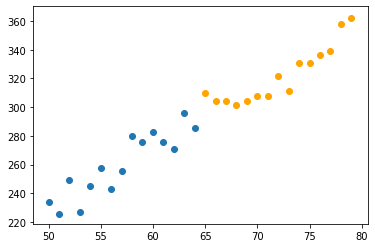

In [28]:
x_test = np.loadtxt("data/overfit_example_x_test.csv", delimiter=",")
y_test = np.loadtxt("data/overfit_example_y_test.csv", delimiter=",") 
plt.scatter(x_train, y_train)
plt.scatter(x_test, y_test, c="orange")
plt.show()

Our simple model performs well on the test set, as it has captured the underlying linear trend:

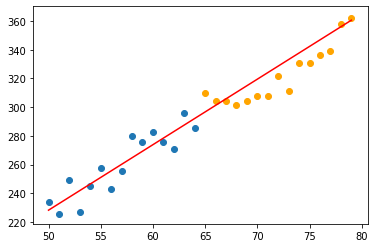

In [29]:
# raw data
plt.scatter(x_train, y_train)
plt.scatter(x_test, y_test, c="orange")

# predictions - plot the full range, both train and test
x = np.concatenate((x_train, x_test))
y_pred = model.predict(x)
plt.plot(x, y_pred, c="r")
plt.show()

Our overfit model, by contrast, performs horribly on the test dataset:

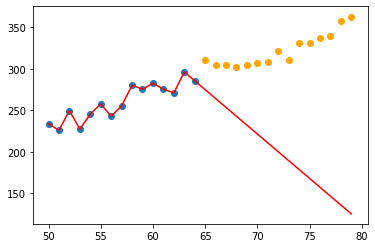

In [30]:
y_pred_overfit_test = model.predict(x_test)
# raw data
plt.scatter(x_train, y_train)
plt.scatter(x_test, y_test, c="orange")

# predictions
y_pred_overfit = model_overfit.predict(x)
plt.plot(x, y_pred_overfit, c="r")
plt.show()

## Train/Test Splits

Because overfitting has such dramatic negative consequences for neural network models, you will often see the evaluation process above repeated for many different types of problems. The dataset that you are using to train your model will be split into two pieces - a *training set* and a (usually smaller) *test set*. The model will be trained using only the data in the training set, and then its accuracy will be evaluated against the test set. This allows us to perform a "fair" comparison of different models that punishes overly complex models that overfit the training data. 

In the subsequent lessons, you should observe that we take this approach, and always work with two different data subsets: `(X_train, y_train)` and `(X_test, y_test)`, due to the concerns discussed in this lesson. 

A common way to split a dataset into train and test subsets is to use the `train_test_split` function from `sklearn`:

In [31]:
from sklearn.model_selection import train_test_split

We can pass this function a `test_size`  argument indicating how many values to extract into the test set - typically, this is set to around `0.2` or `0.25`; we can see how this works using the demonstration below:

In [32]:
x_demo = np.arange(0,100)
y_demo = 2* x_demo + 5
x_demo_train, x_demo_test, y_demo_train, y_demo_test = train_test_split(
    x_demo, 
    y_demo, 
    test_size=0.2,
    random_state=1337
)

Note that the test set size is the specified fraction of the full set size:

In [33]:
print("full size:", len(x_demo))
print("test size:", len(x_demo_test))

full size: 100
test size: 20


We also set the `random_state` argument to seed the random number generator so that we get the same (randomly chosen) result every tiem.

<span style="color:blue;font-weight:bold">Exercise</span>: Let's practice training a model on the training set and then evaluating it on the test set. Perform the following tasks:

* Create a model named `my_model` containing a single layer with one neuron. Use the following argument in the creation of this neuron to help the training process along:

```
kernel_initializer=keras.initializers.constant(2)
```

* Compile your model for training using a `loss` value of `mean_squared_error` and an optimizer created as follows: `keras.optimizers.Adam(lr=0.01)`
* `fit` your model for `50` epochs on the datsets `x_demo_train` and `y_demo_train`
* Create a variable `y_pred_my_model` and assign it the value produced by calling `my_model.predict` on the argument `x_demo_test`
* Make a scatter plot of `x_demo_test` vs. `y_demo_test`
* Overlay a line plot of your predictions `y_pred_my_model` 

Be careful not to delete the `remove_randomness` call at the top of the cell.

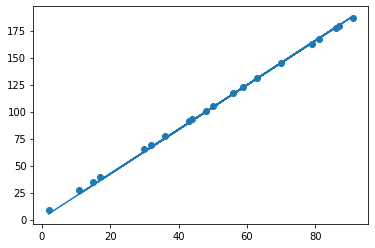

In [40]:
remove_randomness()

my_model = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1,
                          kernel_initializer=keras.initializers.constant(2))
])

my_model.compile(optimizer=keras.optimizers.Adam(lr=0.01), loss="mean_squared_error")
history = my_model.fit(x_demo_train, y_demo_train, epochs=50, verbose=0)

y_pred_my_model = my_model.predict(x_demo_test)

plt.scatter(x_demo_test, y_demo_test)
plt.plot(x_demo_test, y_pred_my_model)

In [40]:
check_variable_definition("my_model")
assert str(type(my_model)) ==  "<class 'tensorflow.python.keras.engine.sequential.Sequential'>", "Your variable <code>my_model</code> does not contain an object of the right type - did you create it using <code>keras.Seqential()</code>?"
assert len(my_model.layers) == 1, "Your model does not contain the correct number of layers."
assert abs(y_pred_my_model[5] - 116.31786) < 0.01, "Your <code>y_pred_my_model</code> values are incorrect - check your training configuration"
success()

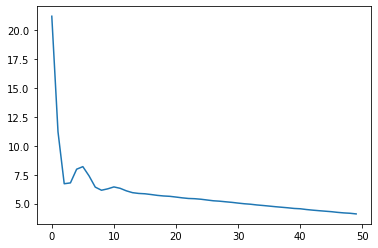

In [49]:
plt.plot(history.history["loss"])